In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Loading the dataset with the help of pandas.
housing=pd.read_csv('housing.csv')

# It will return the information about all the columns(features) present in the dataset like
# null values, datatype etc.
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
# The feature "ocean_proximity" is the categorical attribute i.e. it has the string values.
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
# The describe() method is used to compute the statistical information about the numericals 
# columns like mean, median, max, min value etc. So, it will not include the "ocean_proximity"
# attribute as it is not numerical.

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
# Checking the above results(Is 75% of houses are at latitude 37.710000).
housing[housing['latitude']<=37.71000].count()

longitude             15483
latitude              15483
housing_median_age    15483
total_rooms           15483
total_bedrooms        15319
population            15483
households            15483
median_income         15483
median_house_value    15483
ocean_proximity       15483
dtype: int64

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

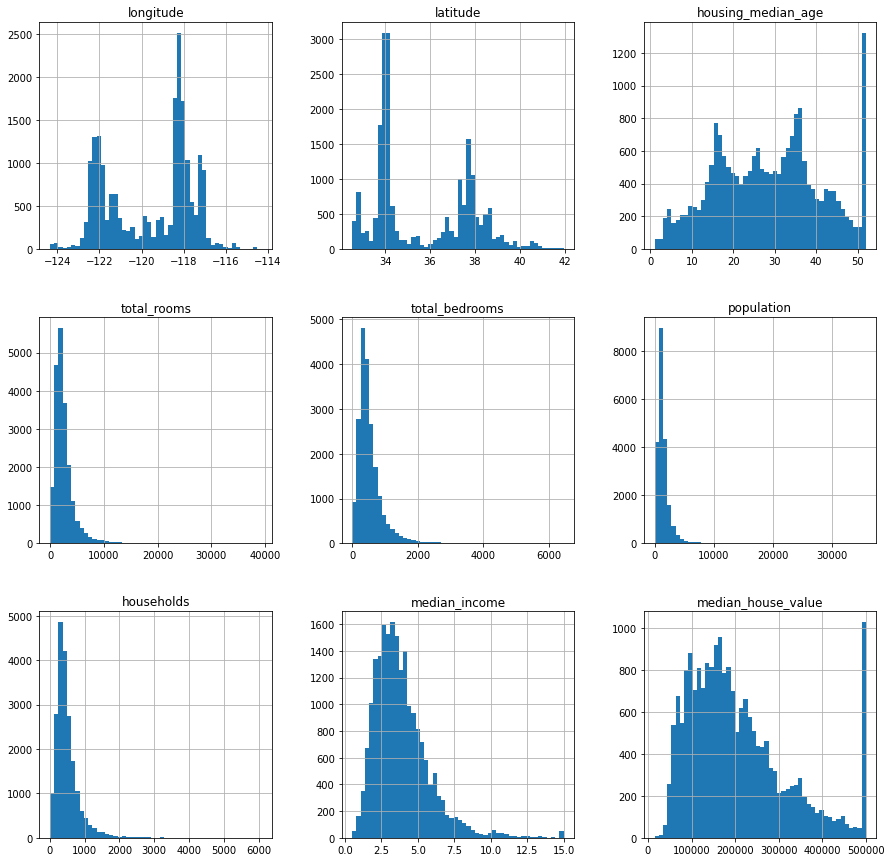

In [6]:
# Ploting the data to get the analyze how the data looks like.
housing.hist(bins=50,figsize=(15,15))

In [7]:
# Splitting the data into training and test set by building our own function. Training data is 
# used to train the model and test set is used to evaluate the model to check the performance.
import numpy as np 
def test_train_split(data,test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_size]
    train_indices=shuffled_indices[test_size:]
    return test_indices, train_indices

In [8]:
test_data,train_data=test_train_split(housing, 0.2)

In [9]:
len(test_data)

4128

In [10]:
len(train_data)

16512

In [11]:
'''If we will use the above method, everytime we will run that function, it will produce different
training and testing set which is not good for our model as we can't feed in the test data.
So, we use the hash i.e. creating a unique indentifier for each of the example and then we are 
going to compute the hash, if the hash is less than 20% then it will go the test set otherwise 
training set. Thus, by doing so the data which is present in training set will never go into 
the test set and vice versa'''
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]



In [12]:
'''Using index as a unique indentifier, but we have to make sure that the data is always
added at the end and no row gets deleted.'''
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [13]:
'''Using the above approach, it might create an problem when the data gets updated. So, 
we are creating new unique indentifer using some features in the dataset like latitude,
longitude as they will never going to chnage for the data'''

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [14]:
'''We can also use sklearn train_test_split which will automatically split the data and is more
faster and efficient from building our own function. Random_state parameter allows us to 
always split the data from same index.'''

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)



In [15]:
'''Pandas cut() function is used to separate the array elements into different bins. The cut()
function is mainly used to perform statistical analysis on scalar data. Now, we can going 
to split our train and test set acc. to the category of the income, so that we have data
which is repersentative.'''

housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64


<AxesSubplot:>

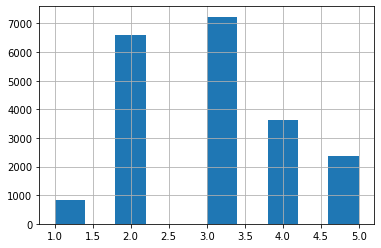

In [16]:
print(housing['income_cat'].value_counts())
# Plotting the above obervations.
housing['income_cat'].hist()

In [17]:
'''Till now, we are splitting the data into sets randomely but it is good only when our dataset
is large, but it will not make sure that now we have all kind of data. So, better to split
the data in a way that it will make sure that pur data will be representative.''' 

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [18]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [19]:
strat_train_set['income_cat'].value_counts()/len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [20]:
'''From the results below, we can see the percentage of the particular set of data 
   in the original data set and the train,test are same.So, we can say that now our 
   train,test is representative of all kind of data.'''
housing['income_cat'].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [21]:
# Droping the column as it is not needed now.
strat_train_set.drop('income_cat',inplace=True,axis=1)
strat_test_set.drop('income_cat',inplace=True,axis=1)

### Visualizing the data

In [22]:
# Copy the data into new dataframe, so that the original set will not manipulated and analyze it.
housing=strat_train_set.copy()

Visualizing geographical data


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

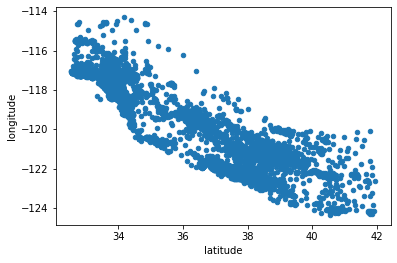

In [23]:
housing.plot(kind='scatter',x='latitude',y='longitude')

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

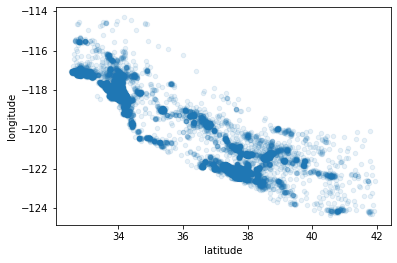

In [24]:
# To see the high density areas.
housing.plot(kind='scatter',x='latitude',y='longitude',alpha=0.1)

'We can see that the price of the house is very much related to the location .i.e. the\narea near the ocean has high prices.'

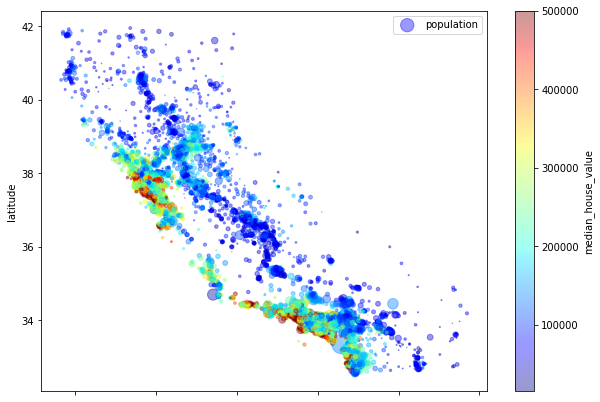

In [25]:
'''The radius of each circle represents the district’s population (option s), and the
color represents the price (option c). We will use a predefined color map (option cmap) 
called "jet", which ranges from blue(low values) to red(high prices).'''

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

'''We can see that the price of the house is very much related to the location .i.e. the
area near the ocean has high prices.'''

In [26]:
# Let's see how the features are related to each using correlation which varies from 0-1.
corr_matrix=housing.corr()

In [27]:
# As median_house_value is completely related to median_house_value.So. it is equal to 1.
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

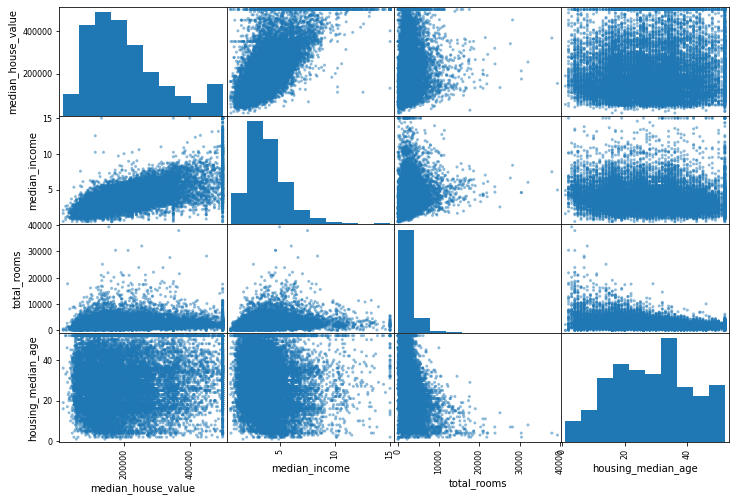

In [28]:
''' Another way to check for correlation between attributes is to use Pandas
"scatter_matrix" function, which plots every numerical attribute against every other
numerical attribute'''

attributes = ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

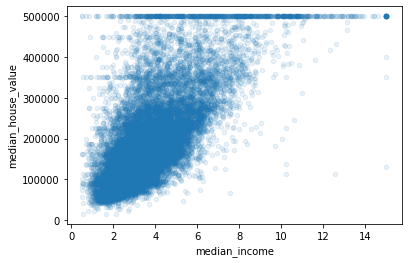

In [29]:
# The most dependent feature on median_house_value is median_income.So, let's plot it.
housing.plot(kind="scatter", x="median_income", y="median_house_value",
 alpha=0.1)

Attribute combinations

In [30]:
# WE will combine various attributes to compute the features which can be useful for our model.ipynb

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]


In [31]:
corr_matrix=housing.corr()

# Seeing the relation of median_house_value with every other attribute.
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

### Prepare data for machine learning model

In [32]:
# Let's separate the features and the labels and try to transform the input data into the required form.


housing=strat_train_set.drop(labels='median_house_value',axis=1)
housing_labels=strat_train_set['median_house_value'].copy()

Now see, in the attribute "total_bedrooms", we have some missing values. To deal with the missing/null values we have certian ideas:-
1. To drop the null values.

2. To drop the whole attribute(if not important).

3. To fill the null values with certain values(like mean,median,zero).



In [33]:
# 1. housing.dropna(subset=["total_bedrooms"])
# 2. housing.drop("total_bedrooms", axis=1)
# 3. median = housing["total_bedrooms"].median()
    # housing["total_bedrooms"].fillna(median, inplace=True)

''' Remember one thing, if we are using option 3 to fill the values then, we have save the median
value to fill it in the test set used for evaluation and also for the new data 
coming with null values.'''

' Remember one thing, if we are using option 3 to fill the values then, we have save the median\nvalue to fill it in the test set used for evaluation and also for the new data \ncoming with null values.'

In [34]:
''' However, sklearn provides a simpler way to do so, SimpleImputer will automatically replace 
the misisng values of the attribute with the median/mean/most_frequent/constant
of that attribute''' 

# Creating object of imputer
imputer= SimpleImputer(strategy="median") 


In [35]:
# Ocean_proximity contains categorical values,So, median value of the string data can't be caculated.

housing_num = housing.drop("ocean_proximity", axis=1)

# Now you can fit the imputer instance to the training data using the fit() method:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [36]:
# It stores the median value of each attribute.
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [37]:
# Once the imputer is trained. now we can apply it to any data. 
X=imputer.transform(housing_num)

In [38]:
#The resultant is an numpy array containing transformed features.
# We need convert it into the pandas DataFrame.
type(X)

numpy.ndarray

In [39]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [40]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


In [41]:
# As we can see above, the median value of the total_bedrooms is 433.0. So, it means 181 null values are filled with the median value.
housing_tr['total_bedrooms'].value_counts()

433.0     181
272.0      44
280.0      44
393.0      43
331.0      41
         ... 
1705.0      1
3984.0      1
1386.0      1
2704.0      1
1661.0      1
Name: total_bedrooms, Length: 1810, dtype: int64

#### Dealing with the categorical values.

In [42]:
housing_cat=housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [43]:
# Since the string value can't be fit into the model, So we have to convert this categorical
# value into the numercial value. We can use the sklearn OrdinalEncoder

ordinal_encoder = OrdinalEncoder()


In [44]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
ordinal_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [45]:
housing_cat_encoded

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [46]:
'''By using the OridnalEncoder,it will succesfully convert the data into the numeric acc. to the
category, but it will create a problem becaus ML model will assume that two nearby
values are more similar than two distant values(like 0 and 1 are more close than 0 and 4)
but in actual it is same.'''

'''To resolve this problme, we are going ot use the OneHotEncoder which will create the binary
attribute per category. In every attribute category, one is considered as hot(1) and 
other are consisdered as cold(0).So, for this dataset it will return 5 binary 
attributes for 5 different categories.'''

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [47]:
# Converting it into an array.
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Custom transforms:-
       
In scikit-learn, Transformers are objects that transform a dataset into a new one to prepare the dataset for predictive modeling, e.g., scaling numeric values, one-hot encoding categoricals, etc.
While scikit-learn has many Transformers, it's often helpful to create our own. This post will look at three ways to make your own Custom Transformers.

#### Creating a Custom Transformer:-
To create a Custom Transformer, we only need to meet a couple of basic requirements:

1. The Transformer is a class.

2. The class inherits from the BaseEstimator and TransformerMixin classes found in the sklearn.base module.

3. The class implements the instance methods fit() and transform(). These methods need to have both X and y parameters, and transform() should return a pandas DataFrame or NumPy array to ensure compatibility with Pipelines.

In [48]:

# It is th index of the columns in the original DataFrame.
room,bedroom,population,household=3,4,5,6
class CombineAttribute(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        room_per_households=X[:,room]/X[:,household]
        population_per_households=X[:,population]/X[:,household]
        if self.add_bedrooms_per_room:
            bedrooms_per_rooms=X[:,bedroom]/X[:,room]
            return np.c_[X, room_per_households, population_per_households,bedrooms_per_rooms]
        else:
            return np.c_[X, room_per_households, population_per_households]

In [49]:
attr_adder = CombineAttribute(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [50]:
# Added 3 extra features.
housing_extra_attribs.shape

(16512, 11)

#### Feature Scaling:-

Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data:the total number of rooms ranges from about 6 to 39,320 , while the median_income only range from 0 to 15.

There are two common ways to get all attributes to have the same scale: min-max
scaling and standardization.

##### Transformation pipeline:-

There are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations.

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a fit_transform() method)

In [51]:
num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('attribs_adder', CombineAttribute()),
 ('std_scaler', StandardScaler()), #Feature Scaling
 ])
housing_num_tr = num_pipeline.fit_transform(housing_num) #returns a numpy array.


In [52]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [53]:
'''There is no need to deal with the numerical and categorical values separately, we
can do it with the help of the sklearn class "ColumnTransformer".It makes our work easier.
 '''

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
housing_prepared = full_pipeline.fit_transform(housing)


In [54]:
# The shape of the result data has 16 columns( )
housing_prepared.shape

(16512, 16)

## Train and Evaluate the model.

In [55]:
''' As we know, it is a regression problem. So, the first model we are going to apply is 
"LinearRegression" and let's check out how it is going ot perform.'''

lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,housing_labels) #Training the model

LinearRegression()

In [56]:
# Selecting some data for evaluation.
data=housing.iloc[:10]
label=housing_labels.iloc[:10]
data=full_pipeline.transform(data)
print("Predictions:", lin_reg.predict(data))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089 206382.40770567 376422.05961781 266569.80764938
 151001.79721225  30119.48436056]


In [57]:
# We can see the difference between the above predicted values and real values below.
print("Actual labels:",list(label))

Actual labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0, 165700.0, 412300.0, 349600.0, 181300.0, 500001.0]


In [58]:
'''Let's calculate the error. There are various metrices used for model evaluation, here we
are using mean_sqaured_error(we can also use various things like mean absolute error or r2_Score provieded by sklearn)
as the named indicates it calculate the square of difference between the actual value
and then divide it by the mean of number of training exmaples.'''

housing_pred=lin_reg.predict(housing_prepared)
error=mean_squared_error(housing_labels,housing_pred)
print(np.sqrt(error)) #Checking the error below, it is pretty much clear that model is prone to underfiting.

68627.87390018745


In [59]:
''' The above error is so large, let's try another model. The next model we are going 
to try "DecisionTreeRegressor" which is again the regression model'''

tree_reg=DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels) #training the model

DecisionTreeRegressor()

In [60]:
housing_pred=tree_reg.predict(housing_prepared)
print("Error:", mean_squared_error(housing_labels,housing_pred))

'''As we can see below, the error comes out to zero, which is quite wonder thing, in such 
cases we have to check that if our model is overfitted to the training set i.e. it is
going to perform well on the training data but will not able to generalize well
when it comes to the new data or test data.'''

Error: 0.0


'As we can see below, the error comes out to zero, which is quite wonder thing, in such \ncases we have to check that if our model is overfitted to the training set i.e. it is\ngoing to perform well on the training data but will not able to generalize well\nwhen it comes to the new data or test data.'

In [61]:
'''To check the above problem, we are going to perform the cross-validation in which 
the training data is divided into folds, one fold is set hold out which is called the
validation set and the remaining train data is used to fit the model and then validation
set is used to evaluate the model. This is performed mainly 10 times i.e. the training data
is divided into 10 folds and everytime each fold is kept for validation and other for
training. This is done using Sklean's cross_val_score'''

scores=cross_val_score(tree_reg,housing_prepared,housing_labels,
scoring="neg_mean_squared_error",cv=10)
cross_score=np.sqrt(-scores)

In [62]:
def display_scores(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean()) #We are calculating the mean of the errors.
    print("Standard deviation:",scores.std())
display_scores(cross_score)

Scores: [73149.69353047 70051.3870017  68355.86895091 70540.31960296
 69401.98686914 77716.07159439 73043.61331975 73905.80496274
 69752.9749814  70508.18181433]
Mean: 71642.59026277982
Standard deviation: 2658.3987575944802


In [63]:
# Let's apply the cross-validation on the LinearRegression.

lin_scores=cross_val_score(lin_reg,housing_prepared,housing_labels, scoring="neg_mean_squared_error",cv=10)
lin_score=np.sqrt(-lin_scores)

In [64]:
display_scores(lin_score)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818065


In [65]:
'''The last model is prone to the overfittng. So, let's try the new model "RandomForestRegressor"
which is kind of model built on the top of the DecisionTreeRegressor. It uses multiple 
DecisionTree and um up the result of the all the sub-models to give final result.
'''

random_reg=RandomForestRegressor()
random_reg.fit(housing_prepared,housing_labels)

RandomForestRegressor()

In [66]:
housing_pred=random_reg.predict(housing_prepared)
error=mean_squared_error(housing_labels,housing_pred)
print(np.sqrt(error))

# The mean squared error is comaparitively less than the above error.

18770.67836366411


In [67]:
rand_scores=cross_val_score(random_reg,housing_prepared,housing_labels,scoring='neg_mean_squared_error',cv=10)
rand_score=np.sqrt(-rand_scores)

In [68]:
display_scores(rand_score)

Scores: [50946.02837005 49071.97198914 46603.40583947 52112.04024275
 47805.3596281  51828.27376656 52732.9228608  50142.39131554
 48319.62354422 53961.84019541]
Mean: 50352.38577520467
Standard deviation: 2251.222577690104


### Hyperparameter Tuning:-

Hyperparamaters tuning is the modt important task of the machine learning algorithm.It helps in determining the best hyperparameters which help in decreasing the cost function. 

We can do it manually like checking different combinations of hyperparameters and choose the optimal one. But, it takes lot of time, Sklearn provides us class GridSerachCV() to do it very easily in less time. All you need todo is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values,using cross-validation. 

In [69]:
# param_gird is the list of the hyperparameters we want to try with, it is passed ot the GridSearchCV().
param_grid=[{'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
{'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}]

In [70]:
forest_reg=RandomForestRegressor()
grid_search= GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [71]:
# It returns the best combination of hyperparameters resulting in least cost.
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [72]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [73]:
# Let's check the errors.
cvres=grid_search.cv_results_
for scoress,paramss in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-scoress),paramss)

63772.254776766895 {'max_features': 2, 'n_estimators': 3}
55206.52777390305 {'max_features': 2, 'n_estimators': 10}
52730.40652782316 {'max_features': 2, 'n_estimators': 30}
60305.99725231219 {'max_features': 4, 'n_estimators': 3}
52573.66994681715 {'max_features': 4, 'n_estimators': 10}
50438.831406357756 {'max_features': 4, 'n_estimators': 30}
59643.87329559089 {'max_features': 6, 'n_estimators': 3}
52608.806587770705 {'max_features': 6, 'n_estimators': 10}
50105.19814667271 {'max_features': 6, 'n_estimators': 30}
59165.19906555255 {'max_features': 8, 'n_estimators': 3}
52299.58696868405 {'max_features': 8, 'n_estimators': 10}
50086.81517536493 {'max_features': 8, 'n_estimators': 30}
62962.67081025931 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54510.277520005635 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59995.638681050885 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52561.86645964173 {'bootstrap': False, 'max_features': 3, 'n_estimators

## Evaluation of the model:-

In [74]:
# Now, we have got the best hyperparameters and model is selected now. So, now check it for the test data.
X_test=strat_test_set.drop("median_house_value",axis=1)
Y_test=strat_test_set["median_house_value"]

In [75]:
X_test_prepared=full_pipeline.transform(X_test)

In [76]:
# Creating the model with best hyperparameters.
final_model=grid_search.best_estimator_
final_pred=final_model.predict(X_test_prepared)

In [77]:
Error_final=mean_squared_error(Y_test,final_pred)
final_error=np.sqrt(Error_final)

In [78]:
final_error

48294.80055218251

In [79]:
from scipy import stats
confidence = 0.95
squared_errors = (final_pred - Y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),scale=stats.sem(squared_errors)))


array([46322.99816907, 50189.19566379])

In [85]:
# Let's use the RandomizedSearchCV() inplace of GrdiSearchCV() which is quite similar but
#instead of using all the possible combinations given, it will use only the random combination.

random_forest=RandomForestRegressor()
param=[{'n_estimators':[3,10,30],'max_features':[2,4,6]},
{'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}]

rand_search=RandomizedSearchCV(random_forest,param,cv=5,return_train_score=True,
scoring='neg_mean_squared_error')
rand_search.fit(housing_prepared,housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_features': [2, 4, 6],
                                         'n_estimators': [3, 10, 30]},
                                        {'bootstrap': [False],
                                         'max_features': [2, 3, 4],
                                         'n_estimators': [3, 10]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [86]:
rand_search.best_params_

{'n_estimators': 30, 'max_features': 6}

In [87]:
cvres=rand_search.cv_results_
for scoress,paramss in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-scoress),paramss)

'''We can see, it is returning the same results as the GridSearchCV() but it is not trying
each combination as above.''' 

55192.10855071989 {'n_estimators': 10, 'max_features': 2}
59717.79467640059 {'n_estimators': 3, 'max_features': 4, 'bootstrap': False}
51911.77637472584 {'n_estimators': 10, 'max_features': 4, 'bootstrap': False}
50559.12074411318 {'n_estimators': 30, 'max_features': 4}
50076.92423796495 {'n_estimators': 30, 'max_features': 6}
54137.46625570069 {'n_estimators': 10, 'max_features': 2, 'bootstrap': False}
52335.48433639639 {'n_estimators': 10, 'max_features': 4}
52104.563152144685 {'n_estimators': 10, 'max_features': 6}
60390.01713690312 {'n_estimators': 3, 'max_features': 3, 'bootstrap': False}
52037.402656981234 {'n_estimators': 10, 'max_features': 3, 'bootstrap': False}
